<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data" data-toc-modified-id="Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#Create-network" data-toc-modified-id="Create-network-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Create network</a></span></li><li><span><a href="#Train-Network" data-toc-modified-id="Train-Network-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Train Network</a></span></li><li><span><a href="#Latent-representation" data-toc-modified-id="Latent-representation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Latent representation</a></span><ul class="toc-item"><li><span><a href="#Extract-latent-data" data-toc-modified-id="Extract-latent-data-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Extract latent data</a></span></li><li><span><a href="#Visualize-latent-data" data-toc-modified-id="Visualize-latent-data-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Visualize latent data</a></span></li></ul></li><li><span><a href="#Classification" data-toc-modified-id="Classification-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Classification</a></span><ul class="toc-item"><li><span><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Logistic Regression</a></span></li><li><span><a href="#Logistic-Regression-Evaluation" data-toc-modified-id="Logistic-Regression-Evaluation-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Logistic Regression Evaluation</a></span></li><li><span><a href="#Support-Vector-Machine" data-toc-modified-id="Support-Vector-Machine-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Support Vector Machine</a></span></li><li><span><a href="#Support-Vector-Machine-Evaluation" data-toc-modified-id="Support-Vector-Machine-Evaluation-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Support Vector Machine Evaluation</a></span></li></ul></li></ul></div>

# Autoencoder
https://www.kaggle.com/shivamb/how-autoencoders-work-intro-and-usecases

When using Autoencoder there is probably no need for dealing with the imbalance in the dataset since the training happens on the majority class only. Maybe for CV or testing this is relevant again?!

## Data

In [1]:
import pandas as pd
import numpy as np
np.set_printoptions(precision=2)

from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler

In [2]:
data = pd.read_csv("../data/creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
X = data.drop('Class', axis=1)
y = data.Class

X_sca_MM = MinMaxScaler().fit_transform(X.values)
X_sca_R = RobustScaler().fit_transform(X.values)
X_sca_Std = StandardScaler().fit_transform(X.values)

## Create network

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import regularizers

print(tf.__version__)

2.0.0


In [5]:
input_dim = X.shape[1]

## input layer 
input_layer = Input(shape=(input_dim,)) # num_features

## encoding part
encoded = Dense(500, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(250, activation='relu')(encoded)
encoded = Dense(5, activation='relu')(encoded)

## decoding part
decoded = Dense(10, activation='tanh')(encoded)
decoded = Dense(20, activation='tanh')(decoded)

## output layer
output_layer = Dense(input_dim, activation='relu')(decoded)

In [6]:
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(learning_rate=0.002, optimizer="adadelta", loss="mse")

In [7]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
dense (Dense)                (None, 500)               15500     
_________________________________________________________________
dense_1 (Dense)              (None, 250)               125250    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 1255      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                60        
_________________________________________________________________
dense_4 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_5 (Dense)              (None, 30)                630   

## Train Network

In [8]:
X_inp = X_sca_Std              # switch between different scaling methods
num_train_samples = 10000

In [9]:
X_norm, X_fraud = X_inp[y == 0], X_inp[y == 1]

In [10]:
autoencoder.fit(X_norm[:num_train_samples], X_norm[:num_train_samples], 
                batch_size=64, epochs=100, 
                shuffle=True, validation_split=0.20);

Train on 8000 samples, validate on 2000 samples
Epoch 1/100
8000/8000 [==============================] - 1s 147us/sample - loss: 1.1825 - val_loss: 1.2823
Epoch 2/100
8000/8000 [==============================] - 0s 44us/sample - loss: 1.1774 - val_loss: 1.2748
Epoch 3/100
8000/8000 [==============================] - 0s 43us/sample - loss: 1.1729 - val_loss: 1.2687
Epoch 4/100
8000/8000 [==============================] - 0s 47us/sample - loss: 1.1693 - val_loss: 1.2640
Epoch 5/100
8000/8000 [==============================] - 0s 45us/sample - loss: 1.1665 - val_loss: 1.2603
Epoch 6/100
8000/8000 [==============================] - 0s 42us/sample - loss: 1.1642 - val_loss: 1.2574
Epoch 7/100
8000/8000 [==============================] - 0s 47us/sample - loss: 1.1622 - val_loss: 1.2548
Epoch 8/100
8000/8000 [==============================] - 0s 49us/sample - loss: 1.1605 - val_loss: 1.2526
Epoch 9/100
8000/8000 [==============================] - 0s 43us/sample - loss: 1.1589 - val_loss: 1.25

8000/8000 [==============================] - 0s 41us/sample - loss: 1.0811 - val_loss: 1.1189
Epoch 78/100
8000/8000 [==============================] - 0s 42us/sample - loss: 1.0805 - val_loss: 1.1178
Epoch 79/100
8000/8000 [==============================] - 0s 42us/sample - loss: 1.0798 - val_loss: 1.1167
Epoch 80/100
8000/8000 [==============================] - 0s 40us/sample - loss: 1.0791 - val_loss: 1.1157
Epoch 81/100
8000/8000 [==============================] - 0s 43us/sample - loss: 1.0785 - val_loss: 1.1146
Epoch 82/100
8000/8000 [==============================] - 0s 51us/sample - loss: 1.0779 - val_loss: 1.1136
Epoch 83/100
8000/8000 [==============================] - 0s 49us/sample - loss: 1.0772 - val_loss: 1.1126
Epoch 84/100
8000/8000 [==============================] - 0s 44us/sample - loss: 1.0766 - val_loss: 1.1115
Epoch 85/100
8000/8000 [==============================] - 0s 42us/sample - loss: 1.0760 - val_loss: 1.1106
Epoch 86/100
8000/8000 [==========================

## Latent representation

### Extract latent data

In [11]:
num_test_samples = 5000

In [12]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

In [13]:
norm_latent = hidden_representation.predict(X_norm[num_train_samples:num_train_samples+num_test_samples])
fraud_latent = hidden_representation.predict(X_fraud)

In [14]:
rep_x = np.append(norm_latent, fraud_latent, axis = 0)
y_n = np.zeros(norm_latent.shape[0])
y_f = np.ones(fraud_latent.shape[0])
rep_y = np.append(y_n, y_f)

### Visualize latent data

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.manifold import TSNE

def plot_cluster(X, y, title='t_SNE'):    
    X = TSNE(n_components=2, random_state=0).fit_transform(X)
    fig = plt.figure(figsize=(12, 12))
    plt.scatter(X[:,0], X[:,1], cmap='coolwarm', c=(y==0), label='No Fraud', linewidth=2)
    plt.scatter(X[:,0], X[:,1], cmap='coolwarm', c=(y==1), label='Fraud', linewidth=2)
    plt.title(title, fontsize=14)
    plt.show()

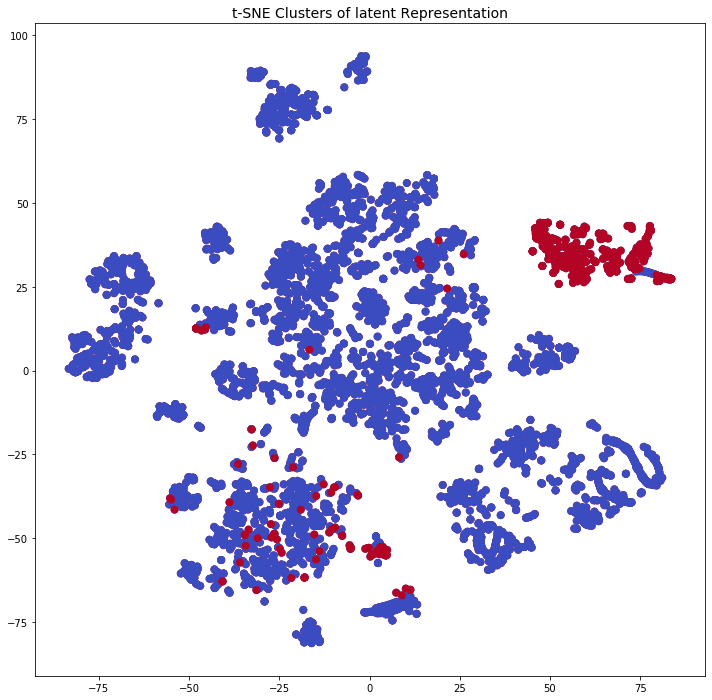

In [16]:
plot_cluster(rep_x, rep_y, title='t-SNE Clusters of latent Representation')

## Classification

In [100]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve

### Logistic Regression

In [101]:
train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size=0.25, random_state=42)
clf = LogisticRegression(solver="lbfgs").fit(train_x, train_y)
pred_y = clf.predict(val_x)

### Logistic Regression Evaluation

In [102]:
print("Classification Report:\n")
print(classification_report(val_y, pred_y))

Classification Report:

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      1240
         1.0       1.00      0.92      0.96       133

    accuracy                           0.99      1373
   macro avg       1.00      0.96      0.98      1373
weighted avg       0.99      0.99      0.99      1373



In [103]:
# print(f"Confusion Matrix:")
# cm = confusion_matrix(val_y, pred_y, normalize='true')
# df_cm = pd.DataFrame(cm, index=['Normal', 'Fraud'], columns=['Normal', 'Fraud'])
# print(df_cm)

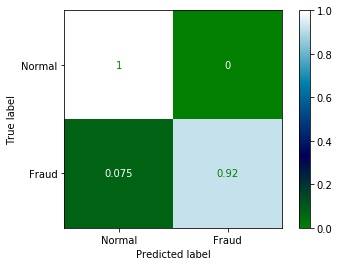

In [104]:
plot_confusion_matrix(clf, val_x, val_y, normalize='true', display_labels=['Normal', 'Fraud'], cmap='ocean')
plt.show()

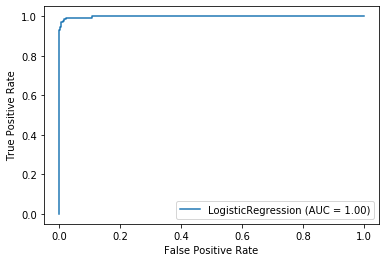

In [105]:
# try also with CV:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py
plot_roc_curve(clf, val_x, val_y)
plt.show()

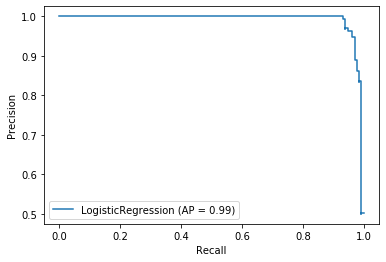

In [106]:
plot_precision_recall_curve(clf, val_x, val_y)
plt.show()

### Support Vector Machine

In [107]:
from sklearn.svm import SVC

In [108]:
train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size=0.25, random_state=42)
clf = SVC(kernel='rbf', degree=5).fit(train_x, train_y)
pred_y = clf.predict(val_x)

### Support Vector Machine Evaluation

In [109]:
print("Classification Report:\n")
print(classification_report(val_y, pred_y))

Classification Report:

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      1240
         1.0       1.00      0.89      0.94       133

    accuracy                           0.99      1373
   macro avg       0.99      0.95      0.97      1373
weighted avg       0.99      0.99      0.99      1373



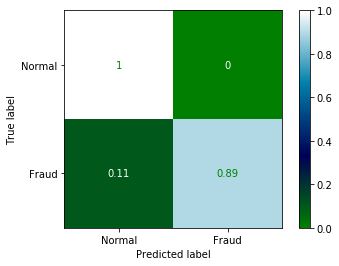

In [110]:
plot_confusion_matrix(clf, val_x, val_y, normalize='true', display_labels=['Normal', 'Fraud'], cmap='ocean')
plt.show()

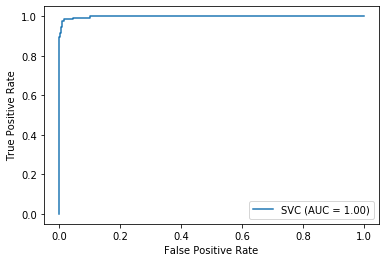

In [111]:
plot_roc_curve(clf, val_x, val_y)
plt.show()

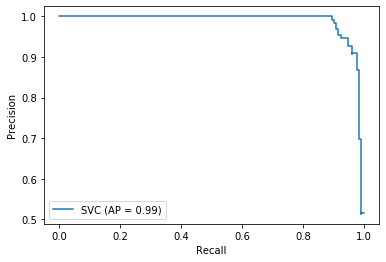

In [112]:
plot_precision_recall_curve(clf, val_x, val_y)
plt.show()